# Ecuación de Lindblad (Runge-Kutta)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
import ipympl
%matplotlib widget
from qutip import *
from scipy.linalg import expm

In [14]:
# Definir los operadores de Pauli
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
sigma_plus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_minus = np.array([[0, 1], [0, 0]], dtype=complex)

# Parámetros del sistema
hbar = 1
Delta_q = 0.1
Omega = 1
gamma = 0.03

# Definir el Hamiltoniano
H = (Delta_q / 2) * sigma_z + (Omega / 2) * (sigma_plus + sigma_minus)

# Operadores de Lindblad
L1 = sigma_minus  # Decaimiento
L2 = sigma_z  # Dephasing

# Estado inicial en forma de matriz densidad (estado puro |0>)
rho_initial = np.array([[1, 0], [0, 0]], dtype=complex)

# Tiempos de integración
t_points = 1000
t_max = 100
t = np.linspace(0, t_max, t_points)
dt = t[1] - t[0]

# Inicializar la matriz densidad para todos los tiempos
rho_t = np.zeros((t_points, 2, 2), dtype=complex)
rho_t[0] = rho_initial

In [15]:
# Definir el conmutador y el anticommutador
def commutator(A, B):
    return np.dot(A, B) - np.dot(B, A)

def anticommutator(A, B):
    return np.dot(A, B) + np.dot(B, A)

In [16]:
def lindblad_rhs(rho, H, L1, L2, gamma):
    # Parte unitaria
    drho_dt_unitary = -1j * commutator(H, rho)
    
    # Términos de Lindblad (decoherencia)
    L1_rho_L1dagger = np.dot(L1, np.dot(rho, L1.conj().T))
    L2_rho_L2dagger = np.dot(L2, np.dot(rho, L2.conj().T))
    
    L1dagger_L1_rho = np.dot(L1.conj().T, np.dot(L1, rho))
    L2dagger_L2_rho = np.dot(L2.conj().T, np.dot(L2, rho))
    
    rho_L1dagger_L1 = np.dot(rho, np.dot(L1.conj().T, L1))
    rho_L2dagger_L2 = np.dot(rho, np.dot(L2.conj().T, L2))
    
    drho_dt_lindblad = gamma * (L1_rho_L1dagger + L2_rho_L2dagger - 0.5 * (L1dagger_L1_rho + rho_L1dagger_L1 + L2dagger_L2_rho + rho_L2dagger_L2))
    
    return drho_dt_unitary + drho_dt_lindblad

def runge_kutta_step(rho, H, L1, L2, gamma, dt):
    k1 = lindblad_rhs(rho, H, L1, L2, gamma)
    k2 = lindblad_rhs(rho + 0.5 * dt * k1, H, L1, L2, gamma)
    k3 = lindblad_rhs(rho + 0.5 * dt * k2, H, L1, L2, gamma)
    k4 = lindblad_rhs(rho + dt * k3, H, L1, L2, gamma)
    return rho + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

In [17]:
# Resolver la ecuación de Lindblad usando el método de Runge-Kutta de Orden 4
for i in range(1, t_points):
    rho_t[i] = runge_kutta_step(rho_t[i - 1], H, L1, L2, gamma, dt)

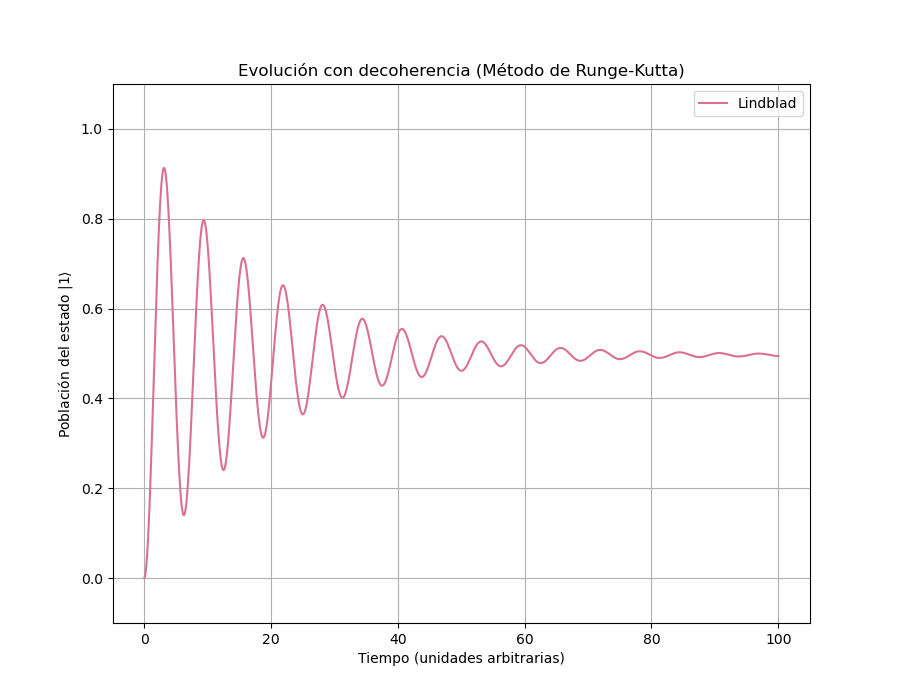

In [18]:
# Calcular la probabilidad de ocupación del estado excitado en función del tiempo
excited_state_population = np.real(rho_t[:, 1, 1])

# Graficar
plt.figure(figsize=(9, 7))
plt.plot(t, excited_state_population, color='palevioletred', label='Lindblad')
plt.xlabel('Tiempo (unidades arbitrarias)')
plt.ylabel(r'Población del estado $|1\rangle$')
plt.title('Evolución con decoherencia (Método de Runge-Kutta)')
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()